<a href="https://colab.research.google.com/github/youkjang/Climate_Chage/blob/main/Bias_Correction_with_CMIP6_Projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bias Correction of Max Temperature CMIP6 Projection

###Projection of Max Temperature in MD
- Model: GFDL-ESM4 among CMIP6
- Experiment: historical and SSP5-8.5 scenario
- Observed (LOCA tasmax, 1995–2014) as reference: LOCA is already tuned to match historical observations
- Region: Maryland (Lat: 36–40, Lon: 280–285)

###Bias correction methods
- Used xclim library
- Mean Bias correction (Scaling)
- Quantile Delta Mappint (QDM)

###Data
- LOCA: https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/
- CMIP6: Google Cloud




In [8]:
!pip install "zarr<3" --quiet
!pip install geopandas cartopy --quiet
!pip install --upgrade xarray gcsfs cftime --quiet
!pip install fsspec --quiet
!pip install xsdba --quiet

In [9]:
!pip install xclim --quiet

In [10]:
!pip install xsdba --quiet

In [11]:
import xsdba as sdba

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zarr
import gcsfs
import cftime

In [13]:
# Define region bounding box
lat_bounds = slice(38.16, 48)
lon_bounds = slice(279.21875, 293)  # LOCA uses 0–360 format

In [14]:
 # Load LOCA tasmax as observed data (1995–2014)

loca_data = 'tasmax.GFDL-CM4.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20220413.n_east.nc'
ds_obs = xr.open_dataset(loca_data)
tas_obs = ds_obs['tasmax'].sel(lat=lat_bounds, lon=lon_bounds, time=slice('1995-01-01', '2014-12-31')) - 273.15
tas_obs.attrs['units'] = 'degC'

In [15]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [16]:
print(df.table_id.unique())

['Amon' '6hrPlev' '3hr' 'day' 'EmonZ' 'E3hr' '6hrPlevPt' 'AERmon' 'LImon'
 'CFmon' 'Lmon' 'fx' 'SImon' 'Ofx' 'Omon' 'EdayZ' 'Emon' 'CFday' 'AERday'
 'Eday' 'Oyr' 'Eyr' 'Oday' 'SIday' 'AERmonZ' '6hrLev' 'E1hrClimMon'
 'CF3hr' 'AERhr' 'Odec' 'Oclim' 'Efx' 'Aclim' 'SIclim' 'IfxGre' 'ImonGre'
 'Eclim']


In [17]:
print(df.activity_id.unique())

['HighResMIP' 'CMIP' 'CFMIP' 'ScenarioMIP' 'AerChemMIP' 'RFMIP' 'FAFMIP'
 'DAMIP' 'LUMIP' 'CDRMIP' 'GMMIP' 'C4MIP' 'OMIP' 'PMIP' 'LS3MIP' 'DCPP'
 'PAMIP' 'ISMIP6']


###Select the daily data of historical in CMIP6

In [18]:
df_ta = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical'")
df_ta.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
961,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
970,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
9537,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,day,tasmax,gr2,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9538,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
37719,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,day,tasmax,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917


###Select the daily data of SSP585 Scenario (CMIP6)

In [19]:
df_ta1 = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585'")
df_ta1.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
11405,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,day,tasmax,gr2,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
11406,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
11539,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
54369,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1,ssp585,r1i1p1f2,day,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190219
66711,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190318


###Select NOAA GFDL ESM4 simulation

In [20]:
df_ta_gfdlesm4 = df_ta.query('institution_id == "NOAA-GFDL" & source_id == "GFDL-ESM4"' )
df_ta_gfdlesm4

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
961,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
970,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
244677,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [21]:
df_ta_gfdlesm4_1 = df_ta1.query('institution_id == "NOAA-GFDL" & source_id == "GFDL-ESM4"' )
df_ta_gfdlesm4_1

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
11539,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701


In [22]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_gfdlesm4.zstore.values[0]

In [23]:
# create a mutable-mapping-style interface to the store
# Access the underlying GCS filesystem and append the zstore path
# to create the full path for the zarr store
mapper = gcs.get_mapper(zstore)
zstore

'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r2i1p1f1/day/tasmax/gr1/v20180701/'

###Load CMIP6 data as using zarr

In [24]:
# Load raw GCM tasmax (historical)

ds_hist = xr.open_zarr(gcs.get_mapper(df_ta_gfdlesm4.zstore.values[0]), decode_times=True)

In [25]:
ds_hist = xr.decode_cf(ds_hist)

In [26]:
tas_hist = ds_hist['tasmax'].sel(lat=lat_bounds, lon=lon_bounds, time=slice('1995-01-01', '2014-12-31')) - 273.15
tas_hist.attrs['units'] = 'degC'

In [27]:
ds_fut = xr.open_zarr(gcs.get_mapper(df_ta_gfdlesm4_1.zstore.values[0]), consolidated=True)
tas_fut = ds_fut['tasmax'].sel(lat=lat_bounds, lon=lon_bounds, time=slice('2041-01-01', '2060-12-31')) - 273.15
tas_fut.attrs['units'] = 'degC'

In [28]:
tas_fut

<xarray.DataArray 'tasmax' (time: 7300, lat: 10, lon: 11)> Size: 3MB
dask.array<sub, shape=(7300, 10, 11), dtype=float32, chunksize=(420, 10, 11), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 80B 38.5 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5
  * lon      (lon) float64 88B 279.4 280.6 281.9 283.1 ... 289.4 290.6 291.9
  * time     (time) object 58kB 2041-01-01 12:00:00 ... 2060-12-31 12:00:00
Attributes:
    units:    degC

In [29]:
tas_hist

<xarray.DataArray 'tasmax' (time: 7300, lat: 10, lon: 11)> Size: 3MB
dask.array<sub, shape=(7300, 10, 11), dtype=float32, chunksize=(419, 10, 11), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * lat      (lat) float64 80B 38.5 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5
  * lon      (lon) float64 88B 279.4 280.6 281.9 283.1 ... 289.4 290.6 291.9
  * time     (time) object 58kB 1995-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    units:    degC

In [30]:
tas_obs

<xarray.DataArray 'tasmax' (time: 7305, lat: 153, lon: 221)> Size: 988MB
array([[[ 10.123535  ,   9.274139  ,   8.585876  , ...,          nan,
                  nan,          nan],
        [ 10.011475  ,   9.745361  ,   9.533142  , ...,          nan,
                  nan,          nan],
        [  9.750763  ,   9.274628  ,   9.186432  , ...,          nan,
                  nan,          nan],
        ...,
        [ -2.414795  ,  -2.3894958 ,  -2.2584229 , ...,  -4.322418  ,
          -3.7099304 ,  -2.884369  ],
        [ -2.6513672 ,  -2.7746582 ,  -2.5737915 , ...,  -4.703766  ,
          -4.337677  ,  -4.52182   ],
        [ -2.8547668 ,  -2.8174133 ,  -2.7598267 , ...,  -4.5517273 ,
          -4.291809  ,  -4.601959  ]],

       [[ 12.018707  ,  11.319702  ,  11.141724  , ...,          nan,
                  nan,          nan],
        [ 12.207397  ,  12.191589  ,  12.260712  , ...,          nan,
                  nan,          nan],
        [ 12.413849  ,  12.190521  ,  12.406189  , ...,          nan,
                  nan,          nan],
...
        [ -5.5168457 ,  -5.4817505 ,  -5.3405457 , ...,  -1.1396484 ,
          -0.8746948 ,  -0.41384888],
        [ -5.1316833 ,  -5.228882  ,  -5.0479736 , ...,  -1.6353455 ,
          -1.256073  ,  -0.7201233 ],
        [ -5.055176  ,  -4.997772  ,  -4.7863464 , ...,  -1.8858337 ,
          -1.5776672 ,  -1.2692871 ]],

       [[ 15.7126465 ,  14.8559265 ,  13.997162  , ...,          nan,
                  nan,          nan],
        [ 15.98526   ,  15.654236  ,  15.031891  , ...,          nan,
                  nan,          nan],
        [ 15.3567505 ,  14.6922    ,  15.042175  , ...,          nan,
                  nan,          nan],
        ...,
        [ -6.0310364 ,  -6.0620117 ,  -6.237335  , ...,  -5.564453  ,
          -5.404297  ,  -5.0371704 ],
        [ -5.9943542 ,  -6.2263794 ,  -6.08197   , ...,  -5.8307495 ,
          -5.5270996 ,  -5.094208  ],
        [ -5.912506  ,  -5.9956055 ,  -6.0802    , ...,  -5.795166  ,
          -5.506012  ,  -5.292145  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 2kB 279.2 279.3 279.3 279.4 ... 292.8 292.9 293.0
  * lat      (lat) float64 1kB 38.22 38.28 38.34 38.41 ... 47.59 47.66 47.72
  * time     (time) datetime64[ns] 58kB 1995-01-01T12:00:00 ... 2014-12-31T12...
Attributes:
    units:    degC

###Data loaded with zarr needs to convert time dimension

In [31]:
tas_hist['time'] = tas_hist['time'].astype('datetime64[ns]')
tas_fut['time'] = tas_fut['time'].astype('datetime64[ns]')

In [32]:
print(tas_hist.time.dtype)
print(tas_fut.time.dtype)

datetime64[ns]
datetime64[ns]


In [33]:
tas_obs = tas_obs.rename("tasmax")
tas_obs.name

'tasmax'

###Plot - historical CMIP6

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


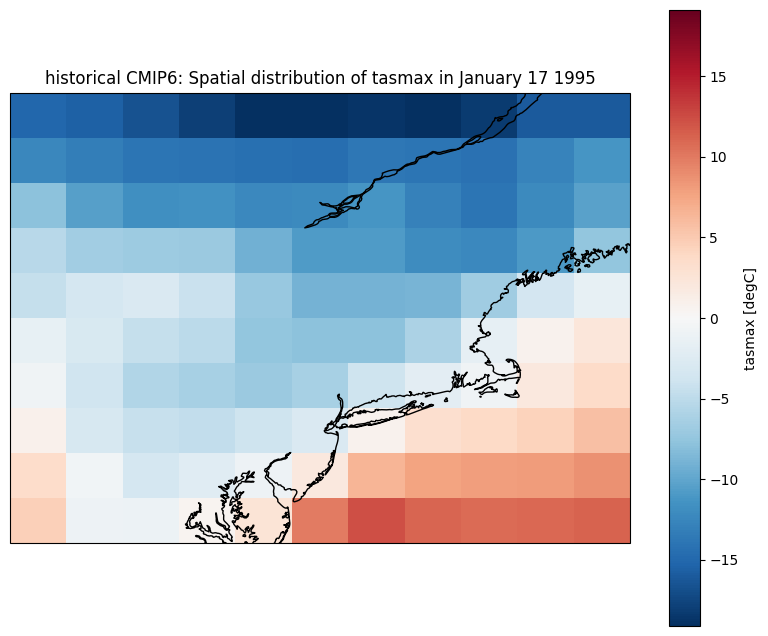

In [34]:
# prompt: how to plot spatial tas_hist for 1995 jan with line for continent

import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import cartopy.crs as ccrs

# Select data for January 1995
tas_hist_jan1995 = tas_hist.sel(time='1995-01-17')


# Plotting
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_hist_jan1995.plot()
ax.coastlines()


ax.set_title('historical CMIP6: Spatial distribution of tasmax in January 17 1995')
plt.show()

###Plot - SSP585 CMIP6

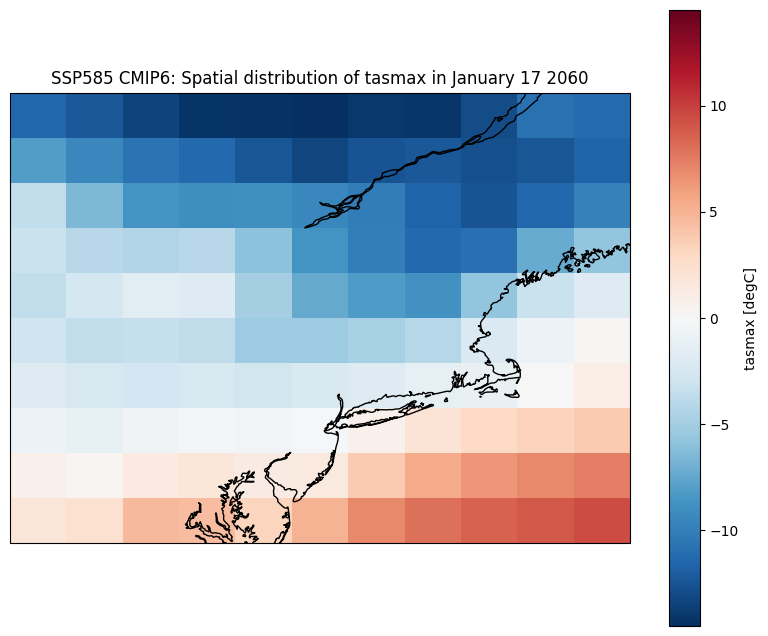

In [35]:
# Select data for January 2060
tas_fut_jan2061 = tas_fut.sel(time='2060-01-17')


# Plotting
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_fut_jan2061.plot()
ax.coastlines()


ax.set_title('SSP585 CMIP6: Spatial distribution of tasmax in January 17 2060')
plt.show()

###Plot - LOCA historical

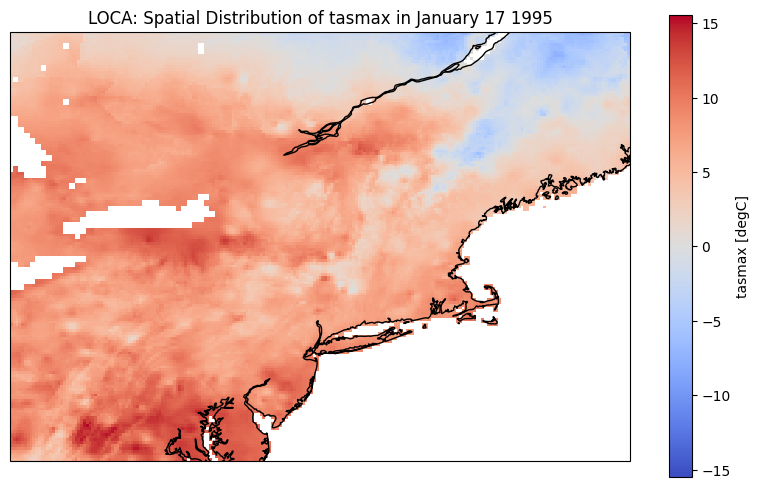

In [36]:
tas_obs_jan1995= tas_obs.sel(time='1995-1-17')

plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
tas_obs_jan1995.plot(cmap='coolwarm')
ax.coastlines()

plt.title('LOCA: Spatial Distribution of tasmax in January 17 1995')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(True)
plt.show()

##Select Maryland Region for Teimseries

In [37]:
lat_bounds_md = slice(36, 40)
lon_bounds_md = slice(280, 285)

In [38]:
tas_obs_md = tas_obs.sel(lat=lat_bounds_md, lon=lon_bounds_md)
tas_hist_md = tas_hist.sel(lat=lat_bounds_md, lon=lon_bounds_md)
tas_fut_md = tas_fut.sel(lat=lat_bounds_md, lon=lon_bounds_md)

In [39]:
# Use spatial average over Maryland
tas_obs_mean = tas_obs_md.mean(dim=["lat", "lon"])
tas_hist_mean = tas_hist_md.mean(dim=["lat", "lon"])
tas_fut_mean = tas_fut_md.mean(dim=["lat", "lon"])

In [40]:
# Assign units attribute back to the meaned dataarrays
tas_obs_mean.attrs['units'] = tas_obs.units
tas_hist_mean.attrs['units'] = tas_hist.units
tas_fut_mean.attrs['units'] = tas_fut.units

In [41]:
# Remove the height coordinate if it exists (dimensions of size 1 are removed)
tas_hist_mean = tas_hist_mean.squeeze()

In [42]:
# Apply correction to future projection
# Compute the DataArray to remove dask chunks along the time dimension
tas_fut_mean_computed = tas_fut_mean.compute()

In [43]:
tas_fut_mean

<xarray.DataArray 'tasmax' (time: 7300)> Size: 29kB
dask.array<mean_agg-aggregate, shape=(7300,), dtype=float32, chunksize=(420,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * time     (time) datetime64[ns] 58kB 2041-01-01T12:00:00 ... 2060-12-31T12...
Attributes:
    units:    degC

In [44]:
tas_hist_mean_reindexed = tas_hist_mean.reindex(time=tas_obs_mean.time, method='nearest')

In [45]:
# Compute the DataArray to remove dask chunks along the time dimension
tas_hist_mean_reindexed_computed = tas_hist_mean_reindexed.compute()

##Quantile Delta Mapping
- adjust the quantiles of model output, while preserving the model-projected climate change (the delta)
- captures variance and extremes

In [46]:
 # Train the bias correction model
adjust = sdba.adjustment.QuantileDeltaMapping.train(
    ref=tas_obs_mean,
    hist=tas_hist_mean_reindexed_computed,
)

##Scaling (Simple Delta or Mean Bias Correction)
- a simple method that adjusts the mean of the modeled data to match observations
- can distort distribution (limited to extremes)

In [47]:
scaling_adjust = sdba.adjustment.Scaling.train(
    ref=tas_obs_mean,
    hist=tas_hist_mean_reindexed_computed,
)

###Applay two corrections to historical in order to validate methods

In [48]:
tas_hist_corrected = adjust.adjust(tas_hist_mean_reindexed_computed)

In [49]:
tas_hist_scaling_corrected = scaling_adjust.adjust(tas_hist_mean_reindexed_computed)

##Apply correction to future projection


In [50]:
tas_fut_corrected = adjust.adjust(tas_fut_mean_computed)
tas_fut_scaling_corrected = scaling_adjust.adjust(tas_fut_mean_computed)

###Validation:  Mean Squared Error (RMSE), Mean Absoulte Error (MAE)

In [51]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# Calculate RMSE for bias (difference between corrected historical mean and observed historical mean)
rmse_bias_hist = mse(tas_obs_mean, tas_hist_mean_reindexed)
rmse_bias_hist_corrected = mse(tas_obs_mean, tas_hist_corrected)
rmse_bias_hist_scaling_corrected = mse(tas_obs_mean, tas_hist_scaling_corrected)


# Calculate MAE for bias (difference between corrected historical mean and observed historical mean)
mae_bias_hist = mae(tas_obs_mean, tas_hist_mean_reindexed)
mae_bias_hist_corrected = mae(tas_obs_mean, tas_hist_corrected)
mae_bias_hist_scaling_corrected = mae(tas_obs_mean, tas_hist_scaling_corrected)

###Model simulation without bias correction: RMSE & MAE

In [52]:
print(f'RMSE for bias (tas_hist): {rmse_bias_hist:.2f} {tas_hist_corrected.units}')
print(f'MAE for bias (tas_hist): {mae_bias_hist:.2f} {tas_hist_corrected.units}')

RMSE for bias (tas_hist): 56.82 degC
MAE for bias (tas_hist): 6.07 degC


###QDM: RMSE & MAE

In [53]:
print(f'RMSE for bias (tas_hist_corrected): {rmse_bias_hist_corrected:.2f} {tas_hist_corrected.units}')
print(f'MAE for bias (tas_hist_corrected): {mae_bias_hist_corrected:.2f} {tas_hist_corrected.units}')

RMSE for bias (tas_hist_corrected): 39.59 degC
MAE for bias (tas_hist_corrected): 4.82 degC


###Scaling: RMSE & MAE

In [54]:
print(f'RMSE for bias (tas_hist_scaling_corrected): {rmse_bias_hist_scaling_corrected:.2f} {tas_hist_corrected.units}')
print(f'MAE for bias (tas_hist_scaling_corrected): {mae_bias_hist_scaling_corrected:.2f} {tas_hist_corrected.units}')

RMSE for bias (tas_hist_scaling_corrected): 37.24 degC
MAE for bias (tas_hist_scaling_corrected): 4.74 degC


###→ Bias corrections reduce RMSE and MAE in both methods.

###Plot of Timeseries

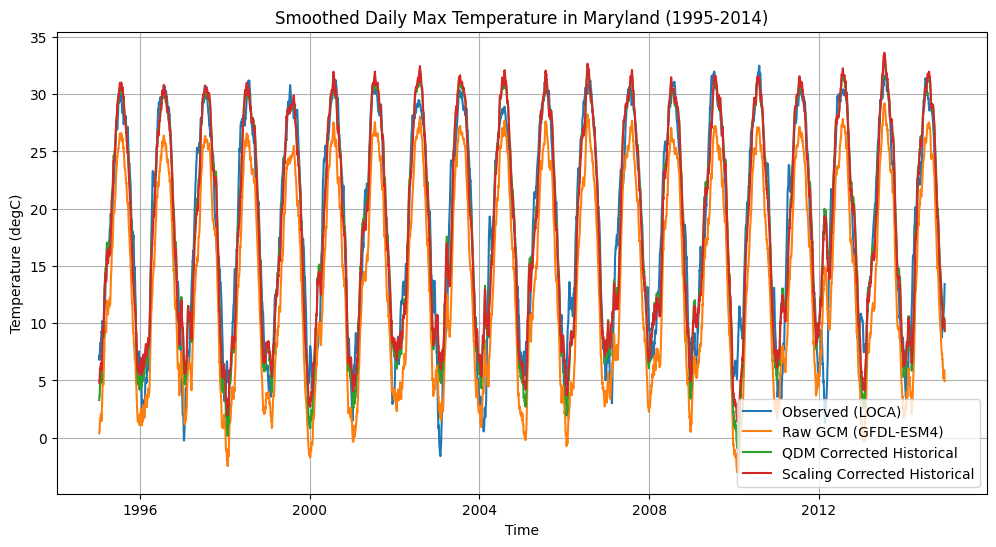

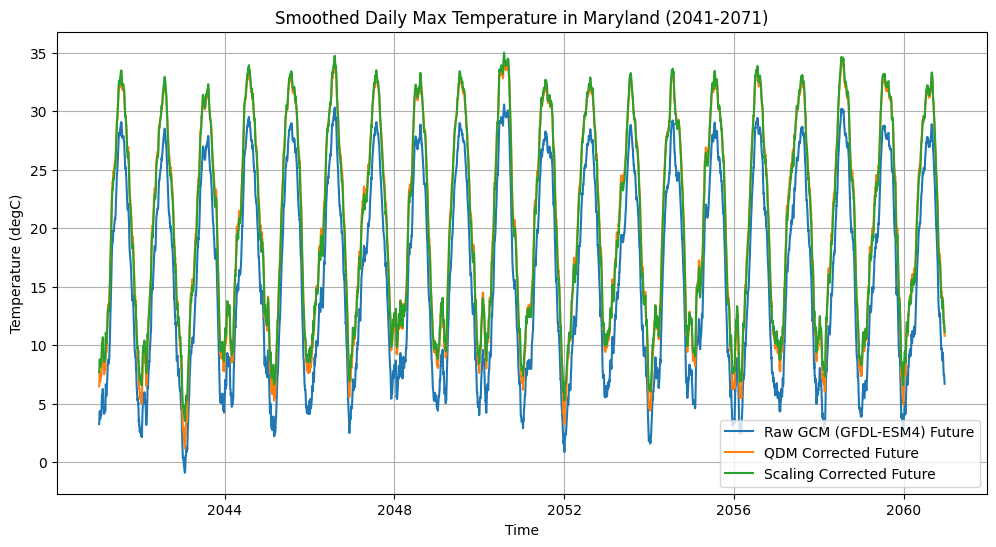

In [55]:
# prompt: Can I plot smoothed time series

import matplotlib.pyplot as plt
# Apply a rolling mean to smooth the time series
window_size = 30  # Adjust the window size as needed for desired smoothing
tas_obs_mean_smooth = tas_obs_mean.rolling(time=window_size, center=True).mean()
tas_hist_mean_smooth = tas_hist_mean_reindexed_computed.rolling(time=window_size, center=True).mean()
tas_hist_corrected_smooth = tas_hist_corrected.rolling(time=window_size, center=True).mean()
tas_hist_scaling_corrected_smooth = tas_hist_scaling_corrected.rolling(time=window_size, center=True).mean()
tas_fut_mean_smooth = tas_fut_mean_computed.rolling(time=window_size, center=True).mean()
tas_fut_corrected_smooth = tas_fut_corrected.rolling(time=window_size, center=True).mean()
tas_fut_scaling_corrected_smooth = tas_fut_scaling_corrected.rolling(time=window_size, center=True).mean()

# Plotting the smoothed time series for historical period
plt.figure(figsize=(12, 6))
tas_obs_mean_smooth.plot(label='Observed (LOCA)')
tas_hist_mean_smooth.plot(label='Raw GCM (GFDL-ESM4)')
tas_hist_corrected_smooth.plot(label='QDM Corrected Historical')
tas_hist_scaling_corrected_smooth.plot(label='Scaling Corrected Historical')
plt.title('Smoothed Daily Max Temperature in Maryland (1995-2014)')
plt.ylabel(f'Temperature ({tas_obs_mean.units})')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the smoothed time series for future period
plt.figure(figsize=(12, 6))
# Note: No observed data for the future period
tas_fut_mean_smooth.plot(label='Raw GCM (GFDL-ESM4) Future')
tas_fut_corrected_smooth.plot(label='QDM Corrected Future')
tas_fut_scaling_corrected_smooth.plot(label='Scaling Corrected Future')
plt.title('Smoothed Daily Max Temperature in Maryland (2041-2071)')
plt.ylabel(f'Temperature ({tas_fut_mean.units})')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

###Compare Means and Distributions
Historical
- QDM corrected
- Scaling corrected
- Raw GCM (no bias correction)
- Obs

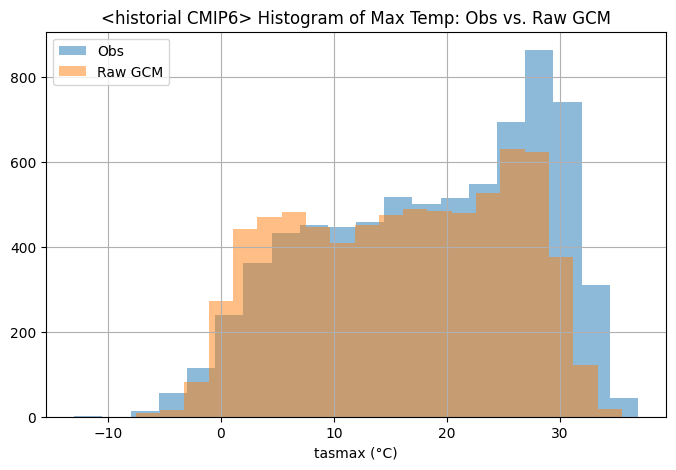

In [56]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(tas_obs_mean, bins=20, alpha=0.5, label='Obs')
plt.hist(tas_fut_mean, bins=20, alpha=0.5, label='Raw GCM')
plt.title("<historial CMIP6> Histogram of Max Temp: Obs vs. Raw GCM")
plt.xlabel("tasmax (°C)")
plt.legend()
plt.grid(True)
plt.show()

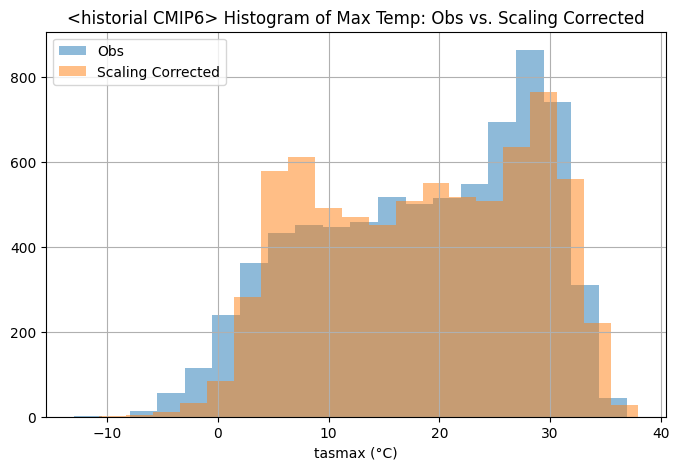

In [57]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(tas_obs_mean, bins=20, alpha=0.5, label='Obs')
plt.hist(tas_hist_scaling_corrected, bins=20, alpha=0.5, label='Scaling Corrected')
plt.title("<historial CMIP6> Histogram of Max Temp: Obs vs. Scaling Corrected")
plt.xlabel("tasmax (°C)")
plt.legend()
plt.grid(True)
plt.show()

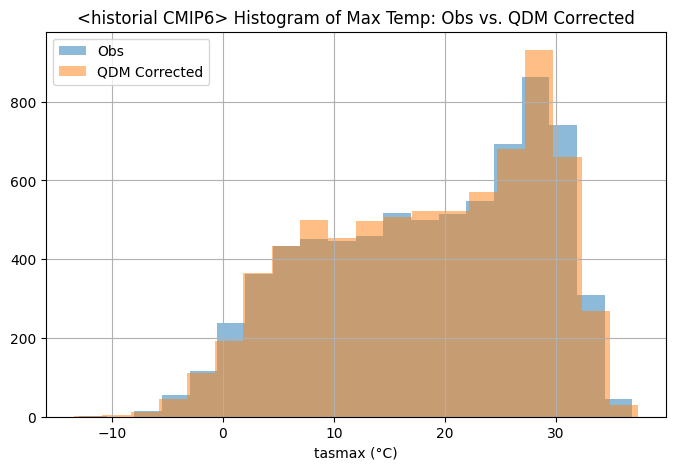

In [58]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(tas_obs_mean, bins=20, alpha=0.5, label='Obs')
plt.hist(tas_hist_corrected, bins=20, alpha=0.5, label='QDM Corrected')
plt.title("<historial CMIP6> Histogram of Max Temp: Obs vs. QDM Corrected")
plt.xlabel("tasmax (°C)")
plt.legend()
plt.grid(True)
plt.show()

###Compare Means and Distributions
SSP585
- QDM corrected
- Scaling corrected
- Raw GCM

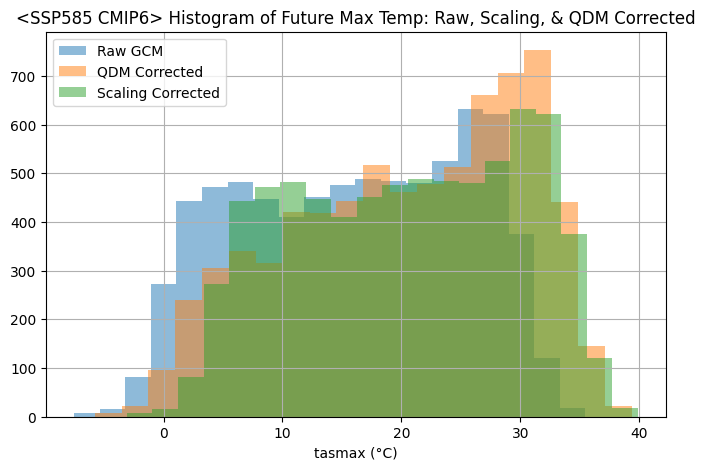

In [59]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(tas_fut_mean, bins=20, alpha=0.5, label='Raw GCM')
plt.hist(tas_fut_corrected, bins=20, alpha=0.5, label='QDM Corrected')
plt.hist(tas_fut_scaling_corrected, bins=20, alpha=0.5, label='Scaling Corrected')
plt.title("<SSP585 CMIP6> Histogram of Future Max Temp: Raw, Scaling, & QDM Corrected")
plt.xlabel("tasmax (°C)")
plt.legend()
plt.grid(True)
plt.show()

###1995~2014 (20 years) Count the numbers of days> 30 degree
For each month, historical CMIP6
- QDM corrected
- Scaling corrected
- Raw GCM
- Obs

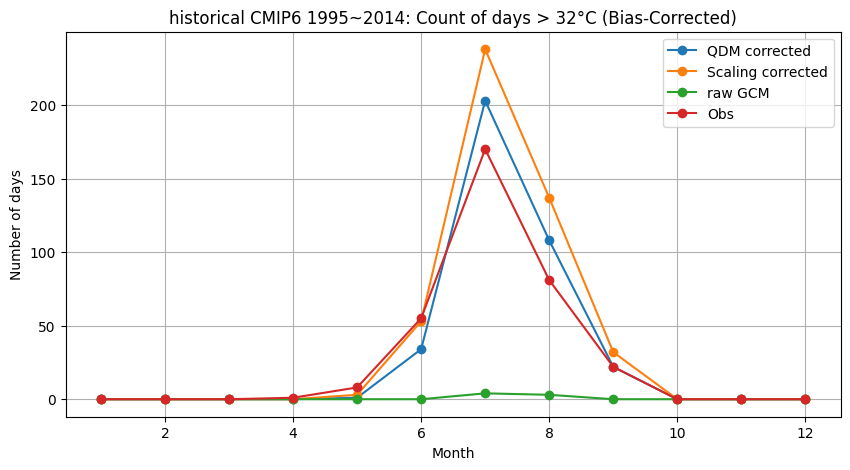

In [73]:
# Define threshold
threshold = 32

# Identify months above threshold
extreme_days = tas_hist_corrected > threshold
extreme_days_scaling = tas_hist_scaling_corrected > threshold
extreme_days_raw = tas_hist_mean_reindexed_computed > threshold
extreme_days_obs = tas_obs_mean > threshold

# Count number of extreme heat days for month
extreme_days_per_month = extreme_days.groupby('time.month').sum()
extreme_days_per_month_scaling = extreme_days_scaling.groupby('time.month').sum()
extreme_days_per_month_raw = extreme_days_raw.groupby('time.month').sum()
extreme_days_per_month_obs = extreme_days_obs.groupby('time.month').sum()

plt.figure(figsize=(10, 5))
extreme_days_per_month.plot(marker='o',label='QDM corrected')
extreme_days_per_month_scaling.plot(marker='o',label='Scaling corrected')
extreme_days_per_month_raw.plot(marker='o',label='raw GCM')
extreme_days_per_month_obs.plot(marker='o',label='Obs')

plt.title(f"historical CMIP6 1995~2014: Count of days > {threshold}°C (Bias-Corrected)")
plt.ylabel("Number of days")
plt.xlabel("Month")
plt.legend()
plt.grid(True)
plt.show()

###2041~2060 (20 years) Count the numbers of days> 33 degree
For each month, SSP585 CMIP6
- QDM corrected
- Scaling corrected
- Raw GCM

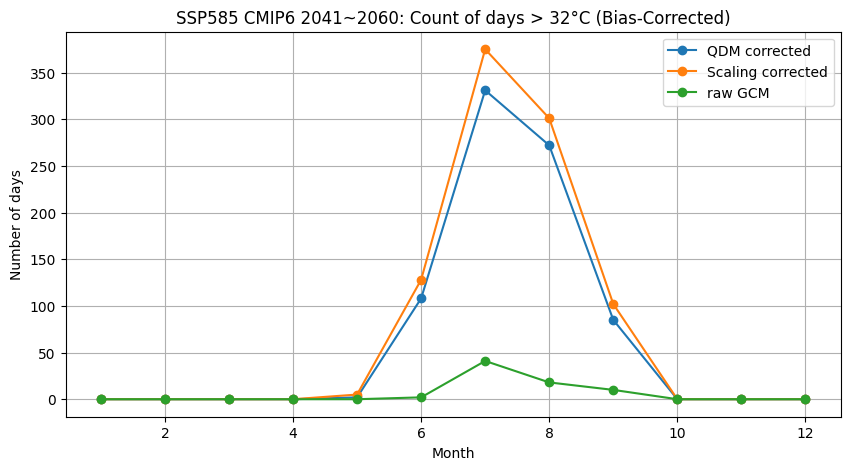

In [72]:
# Define threshold
threshold = 32

# Identify months above threshold
extreme_days1 = tas_fut_corrected > threshold
extreme_days_scaling1 = tas_fut_scaling_corrected > threshold
extreme_days_raw1 = tas_fut_mean_computed > threshold

# Count number of extreme heat months per year
extreme_days_per_month = extreme_days1.groupby('time.month').sum()
extreme_days_per_month_scaling = extreme_days_scaling1.groupby('time.month').sum()
extreme_days_per_month_raw = extreme_days_raw1.groupby('time.month').sum()



plt.figure(figsize=(10, 5))
extreme_days_per_month.plot(marker='o',label='QDM corrected')
extreme_days_per_month_scaling.plot(marker='o',label='Scaling corrected')
extreme_days_per_month_raw.plot(marker='o',label='raw GCM')

plt.title(f"SSP585 CMIP6 2041~2060: Count of days > {threshold}°C (Bias-Corrected)")
plt.ylabel("Number of days")
plt.xlabel("Month")
plt.legend()
plt.grid(True)
plt.show()

###Summary
- Correction used observed LOCA tasmax (1995–2014) as the reference.
- Historical CMIP6: bias-corrected max temperature by Quantile Delta Mapping is closer to observation than bias-correction by Scaling in histogram, and the number of hot days during July.
- GFDL-ESM4 future tasmax under SSP5-8.5 was bias-corrected using Quantile Delta Mapping & Scaling.
- The bias-corrected one (QDM & Scaling) provides a more heatwave impact on Maryland in the future than one without the bias correction (raw GCM).

###Further Study
- Study more simulations from the different models in CMIP6
- Compare SSP585 with other scenarios.
- Bias correction for other variables (precipitation and wind).